<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Add, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Add, Flatten, Dense
from tensorflow.keras.models import Model


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**File Loading**</p>

In [332]:
# Load the dataset
file_path = '/content/Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(file_path)

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Data Pre-Processing**</p>

**Label Encoding**

In [333]:
# Step 1: Label Encoding for categorical columns
label_encoder = LabelEncoder()
for column in ['holiday', 'weather_main', 'weather_description']:
    data[column] = label_encoder.fit_transform(data[column])

**Date-Time Conversions**

In [334]:
# Step 2: Convert 'date_time' column to datetime format
data['date_time'] = pd.to_datetime(data['date_time'])
data.set_index('date_time', inplace=True)

In [335]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,11,288.28,0.0,0.0,40,1,24,5545
2012-10-02 10:00:00,11,289.36,0.0,0.0,75,1,2,4516
2012-10-02 11:00:00,11,289.58,0.0,0.0,90,1,19,4767
2012-10-02 12:00:00,11,290.13,0.0,0.0,90,1,19,5026
2012-10-02 13:00:00,11,291.14,0.0,0.0,75,1,2,4918


**Normalize Dataset**

In [336]:
# Step 3: Normalize the dataset (excluding 'date_time')
#scaler = MinMaxScaler()
#numeric_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
#data[numeric_columns] = scaler.fit_transform(data[numeric_columns])


# Normalize numerical features
scaler = MinMaxScaler()
traffic_scaler = MinMaxScaler()  # Separate scaler for traffic_volume

numeric_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Fit and transform traffic_volume separately
data[['traffic_volume']] = traffic_scaler.fit_transform(data[['traffic_volume']])


**Creating Lag Features**

In [337]:
# Step 4: Create Lag Features (example: 1-hour lag for each numeric column)
#for column in numeric_columns:
 #   data[f'{column}_lag1'] = data[column].shift(1)

# Drop any rows with NaN values resulting from the shift
#data.dropna(inplace=True)



# Define lag steps
lag_steps = [1, 2, 3, 6, 12, 24]
for lag in lag_steps:
    data[f'traffic_volume_lag_{lag}'] = data['traffic_volume'].shift(lag)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)


In [339]:
# prompt: handle outliers

# Assuming 'data' DataFrame is already loaded and preprocessed as in the previous code.

# IQR Method for outlier detection and handling
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the bounds
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Example usage: Handling outliers in 'traffic_volume'
data = handle_outliers_iqr(data, 'traffic_volume')

# You can apply this function to other relevant numerical columns as well, for example:
# data = handle_outliers_iqr(data, 'temp')
# data = handle_outliers_iqr(data, 'rain_1h')
# ...and so on.


# Z-score method for outlier detection and handling.
def handle_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    df[column] = np.where(z_scores < threshold, df[column], np.nan) #replace with NaN for later imputation
    return df
# Example usage:
data = handle_outliers_zscore(data, 'traffic_volume')

# Impute the NaN values created in the z-score method (using mean imputation as an example)
data['traffic_volume'].fillna(data['traffic_volume'].mean(),inplace=True)

<ipython-input-339-813f9d1b7763>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['traffic_volume'].fillna(data['traffic_volume'].mean(),inplace=True)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing LB LSTM**</p>

In [ ]:
# Step 5: Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Step 6: Prepare the data for LSTM input
# Separate features and target variable
X_train = train_data.drop('traffic_volume', axis=1).values
y_train = train_data['traffic_volume'].values
X_test = test_data.drop('traffic_volume', axis=1).values
y_test = test_data['traffic_volume'].values

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 7: Build the LB-LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Exception ignored in: <function _xla_gc_callback at 0x7eb895885900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_test, y_test), verbose=1)


Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0120 - val_loss: 0.0088
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0122 - val_loss: 0.0090
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0121 - val_loss: 0.0084
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0121 - val_loss: 0.0087
Epoch 8/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0119 - val_loss: 0.0083
Epoch 9/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 10/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 11/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0119 - val_loss: 0.0084
Epoch 12/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

**Validations**

In [ ]:
# Step 9: Make predictions
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

# Calculate metrics in percentage (relative to the mean of y_test)
y_test_mean = np.mean(y_test)
mse_percentage = (mse / y_test_mean) * 100
rmse_percentage = (rmse / y_test_mean) * 100
mae_percentage = (mae / y_test_mean) * 100
r2_percentage = (r2) * 100  # Convert R^2 to percentage

# Print the evaluation metrics
print("Performance Metrics (Absolute):")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print("\nPerformance Metrics (Percentage):")
print(f"MSE (% of mean): {mse_percentage}%")
print(f"RMSE (% of mean): {rmse_percentage}%")
print(f"MAE (% of mean): {mae_percentage}%")
print(f"MAPE (% of mean): {mape}%")
print(f"R2 (% of mean): {r2_percentage}%")


302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Performance Metrics (Absolute):
Mean Squared Error (MSE): 0.00871163186928387
Root Mean Squared Error (RMSE): 0.09333612306756624
Mean Absolute Error (MAE): 0.06743877829628403
R^2 Score: 0.880750069753437
Mean Absolute Percentage Error (MAPE): 28.869265921459743%

Performance Metrics (Percentage):
MSE (% of mean): 1.9482103202170178%
RMSE (% of mean): 20.873058106417208%
MAE (% of mean): 15.08155140518447%
MAPE (% of mean): 28.869265921459743%
R2 (% of mean): 88.0750069753437%


**Plots**

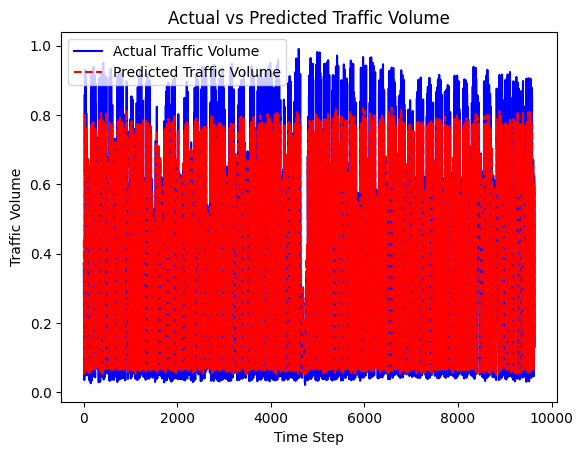

Text(0, 0.5, 'Residuals')

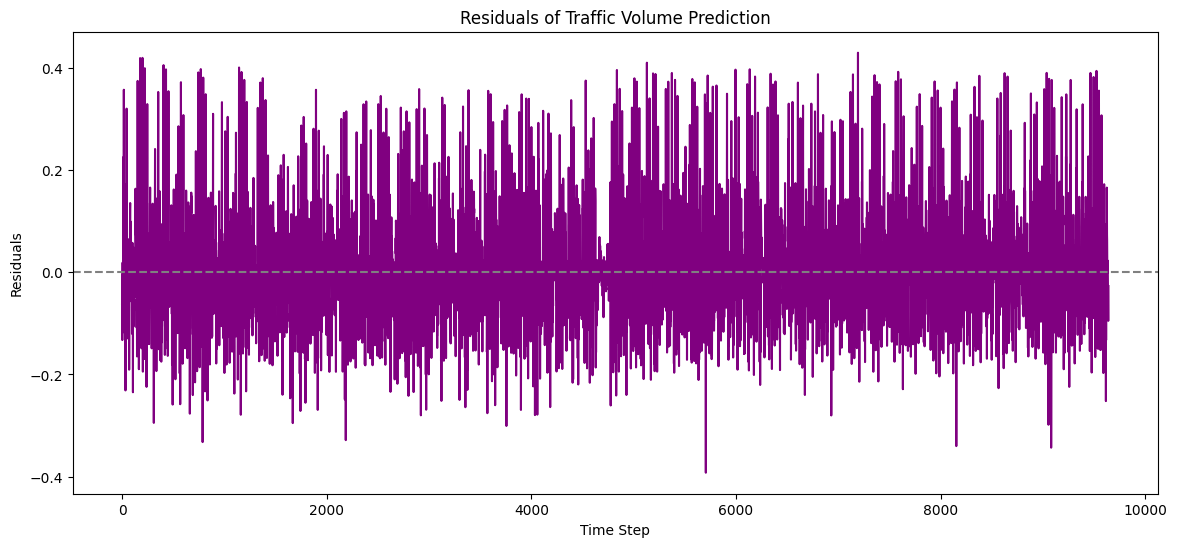

In [ ]:
# Plotting actual vs. predicted values
plt.plot(y_test, label='Actual Traffic Volume', color='blue')
plt.plot(y_pred, label='Predicted Traffic Volume', color='red', linestyle='dashed')
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()

# Plot residuals (errors) if desired
plt.figure(figsize=(14, 6))
plt.plot(y_test - y_pred.flatten(), label='Residuals (Actual - Predicted)', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Traffic Volume Prediction")
plt.xlabel("Time Step")
plt.ylabel("Residuals")

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing Resnet-LSTM**</p>

In [ ]:
# Define features and target
# Check the actual column names in your DataFrame
print(data.columns)

# Assuming 'date_time' is actually named 'date_time_column', adjust accordingly:
X = data.drop(columns=['traffic_volume', 'date_time'])  # Replace 'date_time_column' with the actual column name
y = data['traffic_volume']

# Split data into train and test sets (80% train, 20% test)
split_index = int(len(data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume',
       'traffic_volume_lag_1', 'traffic_volume_lag_2', 'traffic_volume_lag_3',
       'traffic_volume_lag_6', 'traffic_volume_lag_12',
       'traffic_volume_lag_24'],
      dtype='object')


In [ ]:
def create_resnet(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    # Residual block 1 (both Conv1D layers use 64 filters)
    y = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    y = Conv1D(64, kernel_size=3, activation='relu', padding='same')(y)
    x = Add()([x, y])
    x = MaxPooling1D(pool_size=2)(x)

    # Residual block 2 (both Conv1D layers use 128 filters)
    y = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    y = Conv1D(128, kernel_size=3, activation='relu', padding='same')(y)
    x = Conv1D(128, kernel_size=1, padding='same')(x)  # Match dimensions
    x = Add()([x, y])

    x = Flatten()(x)
    output_layer = Dense(64, activation='relu')(x)
    return Model(input_layer, output_layer)

# Reshape data for ResNet
X_train_resnet = np.expand_dims(X_train, axis=2)
X_test_resnet = np.expand_dims(X_test, axis=2)

# Create and compile ResNet model
resnet_model = create_resnet(input_shape=(X_train_resnet.shape[1], 1))
resnet_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train ResNet model
resnet_model.fit(X_train_resnet, y_train, epochs=25, batch_size=128, validation_split=0.2)

# Extract features
X_train_features = resnet_model.predict(X_train_resnet)
X_test_features = resnet_model.predict(X_test_resnet)


Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1770 - val_loss: 0.1168
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1077 - val_loss: 0.1102
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1048 - val_loss: 0.1123
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1043 - val_loss: 0.1103
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1029 - val_loss: 0.1107
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1026 - val_loss: 0.1091
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1016 - val_loss: 0.1090
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0986 - val_loss: 0.1045
Epoch 9/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0982 - val_loss: 0.1047
Epoch 10/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0935 - val_loss: 0.0820
Epoch 11/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0747 - val_loss: 0.0771
Epoch 12/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

In [ ]:
# Reshape for LSTM input
X_train_lstm = np.reshape(X_train_features, (X_train_features.shape[0], 1, X_train_features.shape[1]))
X_test_lstm = np.reshape(X_test_features, (X_test_features.shape[0], 1, X_test_features.shape[1]))

# LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=25, batch_size=128, validation_split=0.2)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0176 - val_loss: 0.0037
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 9/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 10/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 11/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 12/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [ ]:
# Make predictions
y_pred = lstm_model.predict(X_test_lstm)

# Inverse scaling for accuracy calculation using the traffic_scaler
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inv = traffic_scaler.inverse_transform(y_pred)

# Calculate evaluation metrics
rmse_decimal = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mse_decimal = mean_squared_error(y_test_inv, y_pred_inv)
mae_decimal = mean_absolute_error(y_test_inv, y_pred_inv)
mape_decimal = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv))
r2_decimal = r2_score(y_test_inv, y_pred_inv)

# Convert MAPE and R2 to percentage
rmse_percentage = rmse_decimal * 100
mse_percentage = mse_decimal * 100
mae_percentage = mae_decimal * 100
mape_percentage = mape_decimal * 100
r2_percentage = r2_decimal * 100

# Display results
print("Metrics in Decimal Format:")
print(f"RMSE: {rmse_decimal}, MSE: {mse_decimal}, MAE: {mae_decimal}, MAPE: {mape_decimal}, R2: {r2_decimal}")

print("\nMetrics in Percentage Format:")
print(f"RMSE: {rmse_percentage}%, MSE: {mse_percentage}%, MAE: {mae_percentage}%, MAPE: {mape_percentage}%, R2: {r2_percentage}%")

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Metrics in Decimal Format:
RMSE: 404.3483394858117, MSE: 163497.57964493323, MAE: 278.45136636913736, MAPE: 0.136997370279629, R2: 0.9577873713391069

Metrics in Percentage Format:
RMSE: 40434.833948581174%, MSE: 16349757.964493323%, MAE: 27845.136636913736%, MAPE: 13.6997370279629%, R2: 95.77873713391068%


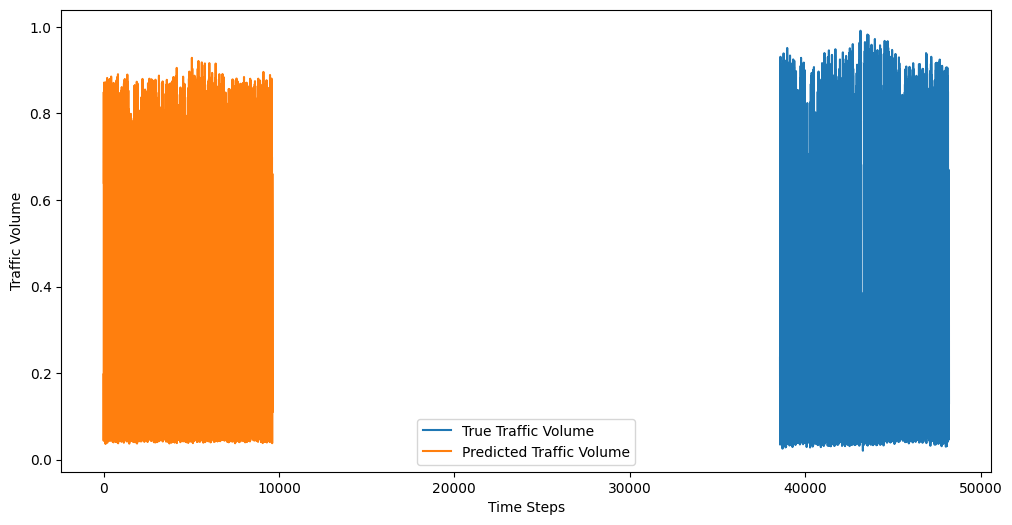

In [ ]:
# Step 11: Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Traffic Volume')
plt.plot(y_pred, label='Predicted Traffic Volume')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing KNN-LSTM**</p>

In [ ]:
# Set up KNN for feature extraction
knn = NearestNeighbors(n_neighbors=6)
knn.fit(X_train)


NearestNeighbors(n_neighbors=6)

In [ ]:
# Find K nearest neighbors in the training set for each sample in the test set
_, knn_indices = knn.kneighbors(X_test) # This line is added


In [ ]:
# Use the mean of each neighbor’s traffic volume as an additional feature for LSTM
X_test_knn_feature = []
for indices in knn_indices:
    X_test_knn_feature.append(y_train.iloc[indices].mean())
X_test_knn_feature = np.array(X_test_knn_feature).reshape(-1, 1)

# Add KNN-derived feature to train and test sets
X_train_with_knn = np.hstack([X_train, np.zeros((X_train.shape[0], 1))])  # add dummy column to match shape
X_test_with_knn = np.hstack([X_test, X_test_knn_feature])

In [ ]:
# Reshape for LSTM input (samples, time steps, features)
X_train_lstm = X_train_with_knn.reshape((X_train_with_knn.shape[0], 1, X_train_with_knn.shape[1]))
X_test_lstm = X_test_with_knn.reshape((X_test_with_knn.shape[0], 1, X_test_with_knn.shape[1]))

# Define the LSTM model with 3 LSTM layers
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50, activation='relu', return_sequences=True),  # Second LSTM layer
    LSTM(50, activation='relu'),  # Third LSTM layer without return_sequences
    Dense(1)
])


# Compile the model
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Fit the model
history = model.fit(X_train_lstm, y_train, epochs=125, batch_size=128, validation_data=(X_test_lstm, y_test), verbose=1)


Epoch 1/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 2/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 3/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 4/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 5/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 6/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 7/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 9/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 10/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 11/125
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 12/125
302/302 ━━━━━━━━━━━━━━━━━

In [ ]:
# Predictions
y_pred = model.predict(X_test_lstm)

# Reshape y_pred to 2D before inverse scaling
y_pred = y_pred.reshape(-1, 1)  # Reshape to (samples, features)

# Rescale predictions and actual values back to original range
y_pred_rescaled = traffic_scaler.inverse_transform(y_pred)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# MAPE calculations
mape_percentage = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100  # in percentage
mape_decimal = mape_percentage / 100  # without percentage

# Convert R2 to percentage form
r2_percentage = r2 * 100

# Print metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2} ({r2_percentage}%)")
print(f"MAPE: {mape_percentage}%")
print(f"MAPE (decimal): {mape_decimal}")

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 151039.92921720768
RMSE: 388.63855858266004
MAE: 260.6547826748757
R^2: 0.9610037502765494 (96.10037502765493%)
MAPE: 12.832388551541543%
MAPE (decimal): 0.12832388551541543


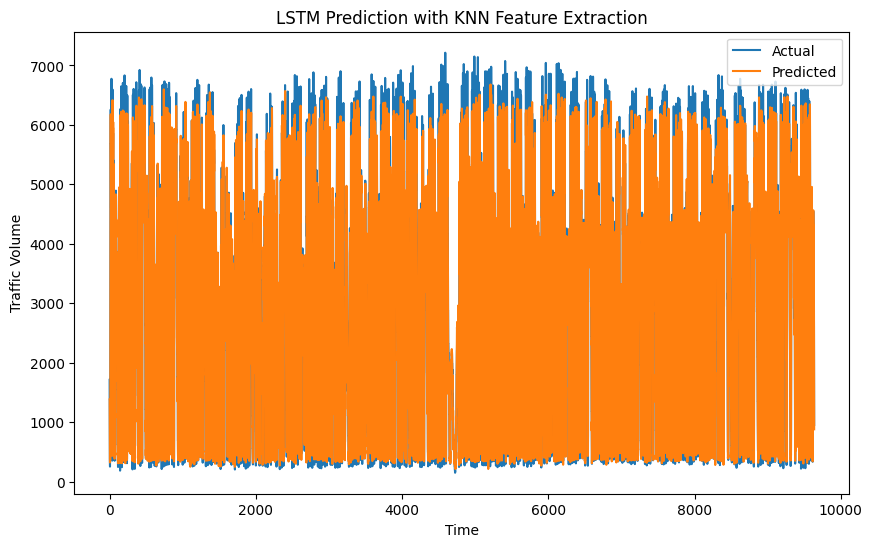

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('LSTM Prediction with KNN Feature Extraction')
plt.legend()
plt.show()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing TCN LSTM**</p>

In [340]:
# Split data into features and target
target = 'traffic_volume'
features = data.drop(columns=['traffic_volume'])
X = features.values
y = data[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape data for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Convert X_train and y_train to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [341]:
# TCN Model for Feature Engineering
def build_tcn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)  # Changed from input_shape[0] to 1
    return Model(inputs, outputs)

# Build and train TCN model
tcn_model = build_tcn_model(X_train.shape[1:])
tcn_model.compile(optimizer='adam', loss='mse')
tcn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Generate TCN-transformed features
X_train_tcn = tcn_model.predict(X_train)
X_test_tcn = tcn_model.predict(X_test)

Epoch 1/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0518 - val_loss: 0.0137
Epoch 2/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0169 - val_loss: 0.0097
Epoch 3/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 4/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0126 - val_loss: 0.0084
Epoch 5/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 6/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0108 - val_loss: 0.0073
Epoch 7/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 8/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 9/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 10/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 11/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 12/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [342]:
# Reshape TCN features for LSTM
X_train_tcn = X_train_tcn.reshape((X_train_tcn.shape[0], X_train_tcn.shape[1], 1))
X_test_tcn = X_test_tcn.reshape((X_test_tcn.shape[0], X_test_tcn.shape[1], 1))

# LSTM Model for Forecasting
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train LSTM model
lstm_model = build_lstm_model(X_train_tcn.shape[1:])
lstm_model.fit(X_train_tcn, y_train, epochs=25, batch_size=32, validation_split=0.2)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


964/964 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0647 - val_loss: 0.0054
Epoch 2/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 3/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 4/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 5/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078 - val_loss: 0.0039
Epoch 6/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 7/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 8/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 9/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 10/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 11/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 12/25
964/964 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0

In [343]:
# Evaluate the LSTM model
y_pred = lstm_model.predict(X_test_tcn)
y_pred = traffic_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = traffic_scaler.inverse_transform(y_test.reshape(-1, 1))

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [344]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error (MSE): 171024.68156444567
Mean Absolute Error (MAE): 287.4073381657519
R-squared (R2): 0.9558439862510151
Mean Absolute Percentage Error (MAPE): 14.25399131719245


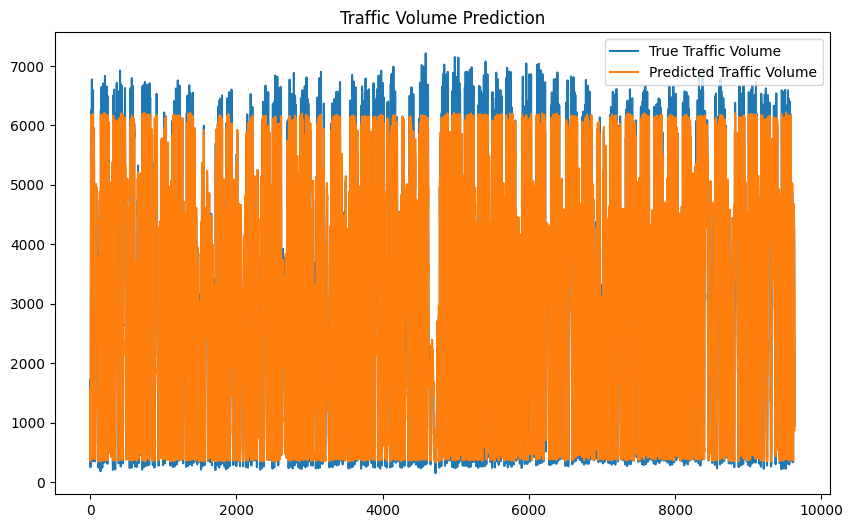

In [345]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Traffic Volume')
plt.plot(y_pred, label='Predicted Traffic Volume')
plt.legend()
plt.title('Traffic Volume Prediction')
plt.show()


